In [0]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.optimizers import RMSprop
from keras import backend as K

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
!git clone https://github.com/iamdsc/humor_detection.git

Cloning into 'humor_detection'...
remote: Enumerating objects: 43, done.
remote: Total 43 (delta 0), reused 0 (delta 0), pack-reused 43
Unpacking objects: 100% (43/43), done.


In [0]:
%cd humor_detection/datasets
!ls

/content/humor_detection/datasets
humorous_oneliners.pickle      proverbs.pickle		 wiki_sentences.pickle
oneliners_incl_doubles.pickle  reuters_headlines.pickle


In [0]:
humour = pd.read_pickle('humorous_oneliners.pickle')
proverb = pd.read_pickle('proverbs.pickle')
wiki = pd.read_pickle('wiki_sentences.pickle')
long_humour = pd.read_pickle('oneliners_incl_doubles.pickle')
reuters = pd.read_pickle('reuters_headlines.pickle')

texts = []
labels = []

# shuffling the different negative samples
neg = proverb+wiki+reuters
np.random.shuffle(neg)

# adding the positive samples
print('No. of positive samples',len(humour))
for line in humour:
  texts.append(line)
  labels.append(1)
  
# taking equal samples from both classes
neg = neg[:len(humour)]

# adding the negative samples
print('No. of negative samples',len(neg))
for line in neg:
  texts.append(line)
  labels.append(0)
  
print('Total no. of samples',len(texts))

No. of positive samples 5251
No. of negative samples 5251
Total no. of samples 10502


In [0]:
maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # only consider top 10000 common words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 16839 unique tokens
Shape of data tensor: (10502, 50)
Shape of labels tensor: (10502,)


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-04-02 10:39:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-02 10:39:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-02 10:39:19--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors:'%len(embeddings_index))

# preparing glove word embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i<max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # for words not in embedding index values will be zeros

Found 400000 word vectors:


In [0]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(64, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                6208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(data,labels, epochs=20, batch_size=32, validation_split=0.1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 9451 samples, validate on 1051 samples
Epoch 1/20





9451/9451 [==============================] - 5s 507us/step - loss: 0.6090 - acc: 0.6833 - val_loss: 0.5602 - val_acc: 0.7212
Epoch 2/20
9451/9451 [==============================] - 4s 423us/step - loss: 0.4246 - acc: 0.8219 - val_loss: 0.3602 - val_acc: 0.8620
Epoch 3/20
9451/9451 [==============================] - 4s 425us/step - loss: 0.2854 - acc: 0.8925 - val_loss: 0.2879 - val_acc: 0.8896
Epoch 4/20
9451/9451 [==============================] - 4s 421us/step - loss: 0.2265 - acc: 0.9157 - val_loss: 0.2391 - val_acc: 0.9077
Epoch 5/20
9451/9451 [==============================] - 4s 416us/step - loss: 0.1938 - acc: 0.9264 - val_loss: 0.2233 - val_acc: 0.9039
Epoch 6/20
9451/9451 [==============================] - 4s 421us/step - loss: 0.1766 - acc: 0.9343 - val_loss: 0.2024 - val_acc: 0.9210
Epoch 7/20
9451/9451 [==========

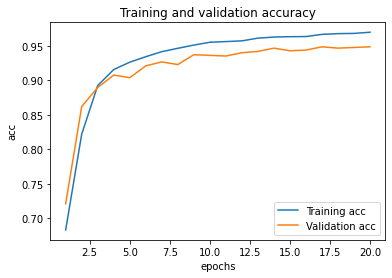

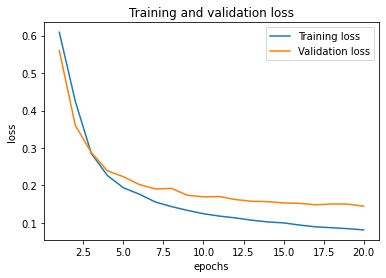

<Figure size 432x288 with 0 Axes>

In [0]:
def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  
  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()

  """plt.plot(epochs, f1, label='Training fmeasure')
  plt.plot(epochs, val_f1, label='Validation fmeasure')
  plt.title('Training and validation fmeasure')
  #plt.xlabel('epochs')
  #plt.ylabel('f1')
  plt.legend()"""
  
  plt.show()
plot_result(history)